In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import curve_fit
import natural_cubic_spline_stack_overflow as ncs # taken from stack overflow
import csv

In [61]:
# Extracting data from the source file into a panda Dataframe
file = "pop_data.xlsx"
# This file should be placed in the same directory as this notebook (on the JupyterHub server)

# We read the data and store it in a Dataframe called "data", using the read_excel() panda function
data = pd.read_excel(file, index_col = None, header = 0, usecols = 'A:H')

In [62]:
print(data)

     TIME  JAN POPULATION  JUL POPULATION  OCT POPULATION  APR POPULATION  \
0    2100             NaN             NaN             NaN             NaN   
1    2025      49128297.0             NaN             NaN             NaN   
2    2024      48619695.0      48821936.0      48999880.0      48701130.0   
3    2023      48085361.0      48320520.0      48486865.0      48205962.0   
4    2022      47486727.0      47781354.0      47940295.0      47609145.0   
..    ...             ...             ...             ...             ...   
422  1604             NaN             NaN             NaN             NaN   
423  1603             NaN             NaN             NaN             NaN   
424  1602             NaN             NaN             NaN             NaN   
425  1601             NaN             NaN             NaN             NaN   
426  1600             NaN             NaN             NaN             NaN   

     1900s POPULATION   HYDE DATA     EU pred  
0                 NaN      

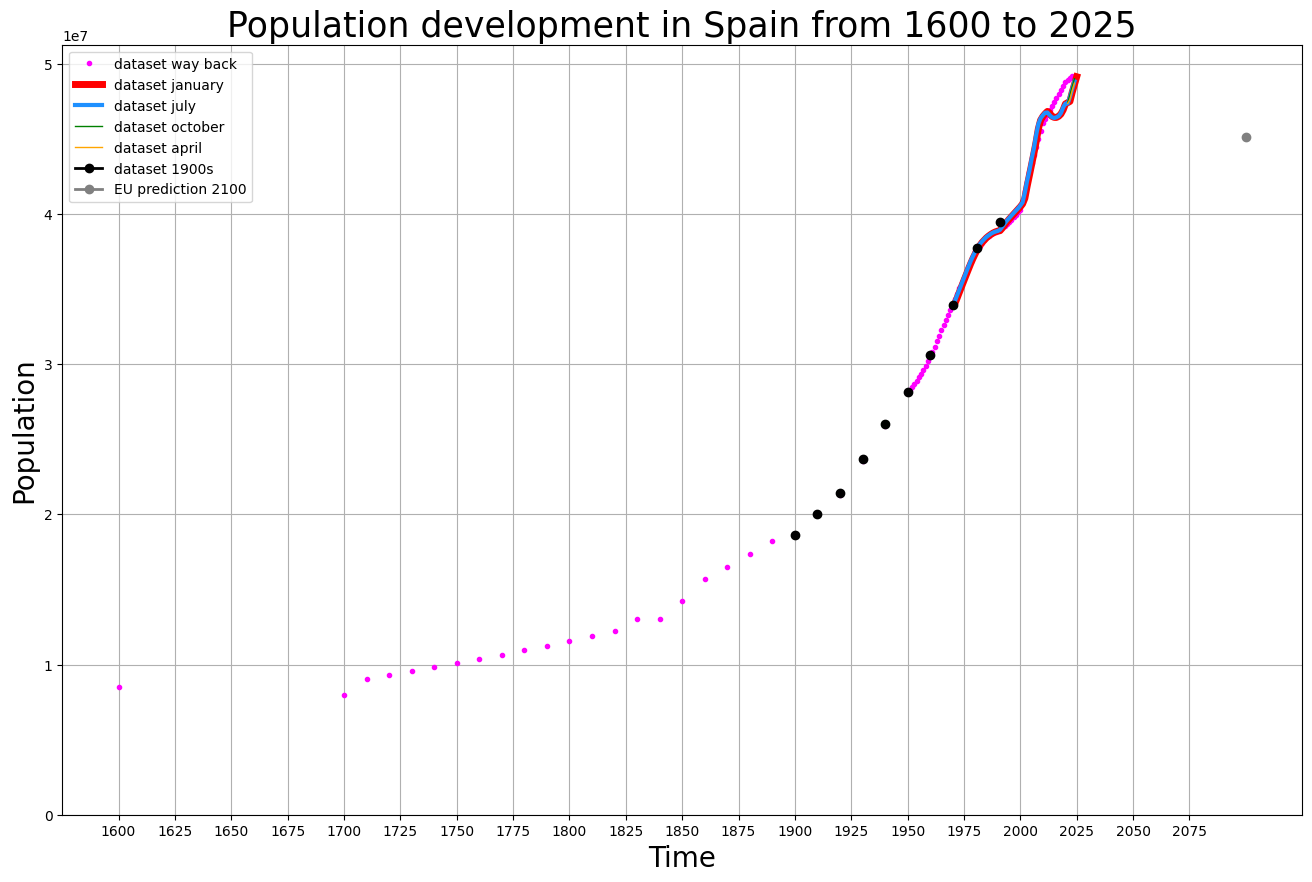

In [96]:
plt.figure(figsize=(16,10))
plt.plot(data["TIME"], data["HYDE DATA"], '.', label="dataset way back", color='magenta')
plt.plot(data["TIME"], data["JAN POPULATION"], label="dataset january", lw=5, color='red')
plt.plot(data["TIME"], data["JUL POPULATION"], label="dataset july", lw=3, color='dodgerblue')
plt.plot(data["TIME"], data["OCT POPULATION"], label="dataset october", lw=1, color='green')
plt.plot(data["TIME"], data["APR POPULATION"], label="dataset april", lw=1, color='orange')
plt.plot(data["TIME"], data["1900s POPULATION"], marker='o', label="dataset 1900s", lw=2, color='black')
plt.plot(data["TIME"], data["EU pred"], marker='o', label="EU prediction 2100", lw=2, color='grey')

plt.legend()
plt.xticks(range(1600, 2100, 25))
plt.ylim(bottom=0)
plt.grid()
plt.xlabel("Time", fontsize=20)
plt.ylabel("Population", fontsize=20)
plt.title("Population development in Spain from 1600 to 2025", fontsize=25)
plt.savefig('pop_raw_data.png')
plt.show()


In [56]:
data_col = pd.read_excel('pop_collection.xlsx', index_col = None, header = 0, usecols = 'A:B')
print(data_col)

     POPULATION  YEAR
0      45121000  2100
1      49128297  2025
2      48619695  2024
3      48085361  2023
4      47486727  2022
..          ...   ...
98      9536161  1730
99      9278427  1720
100     9027659  1710
101     8000000  1700
102     8500000  1600

[103 rows x 2 columns]


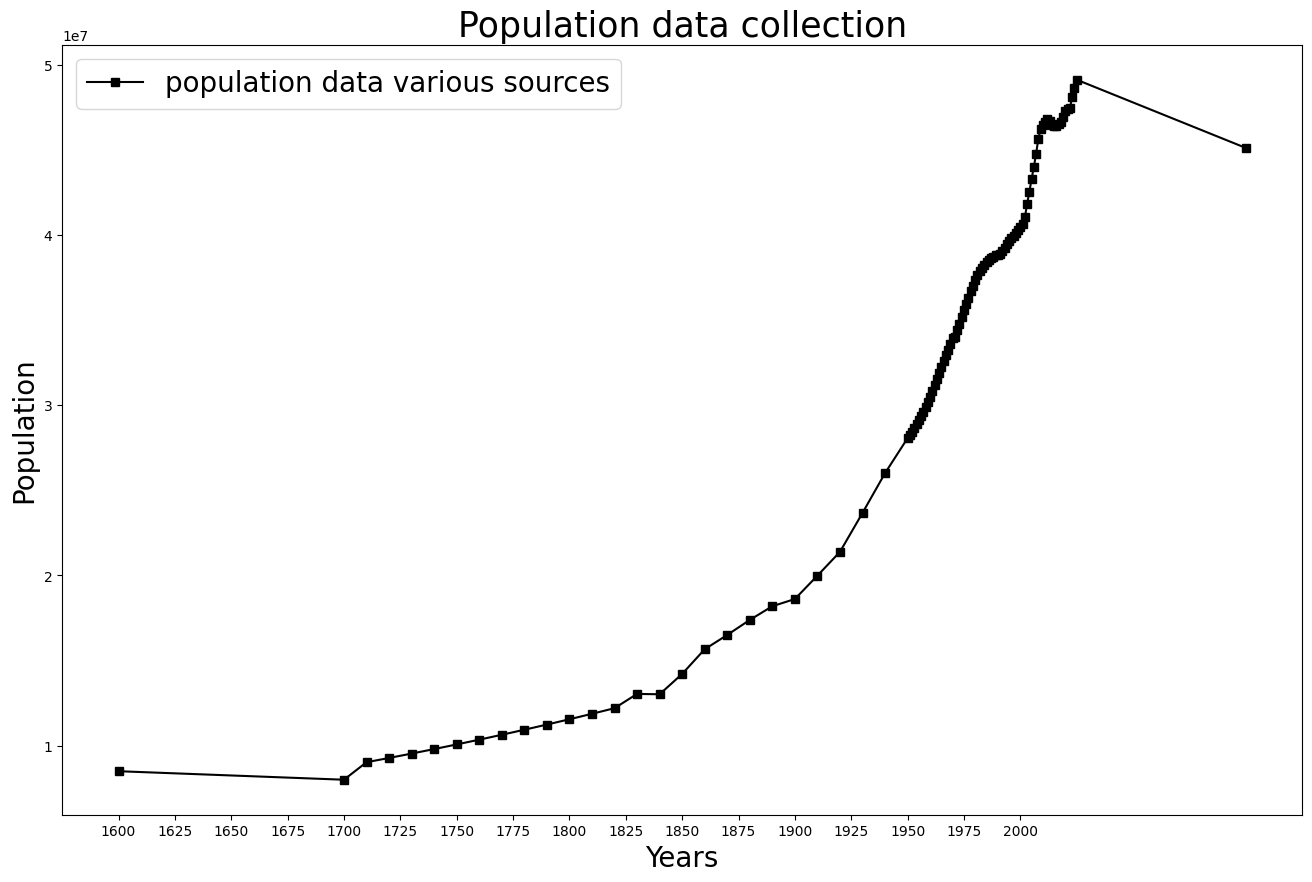

In [97]:
plt.figure(figsize=(16,10))
plt.plot(data_col['YEAR'], data_col['POPULATION'], 's-', color = 'black', markersize = 6, label = f'population data various sources')
plt.legend(loc = 'best', fontsize = 20)
plt.xticks(list(range(1600, 2025, 25)))
plt.xlabel('Years', fontsize = 20)
plt.ylabel('Population', fontsize = 20)
plt.title('Population data collection', fontsize = 25)
plt.savefig('pop_data_collection.png')
plt.show()


In [23]:
def logistic(x:np.ndarray,ti:float,tau:float,C0:float,C1:float) -> np.ndarray:
    """
    General logistic function.
    Arguments:
    - x: np.ndarray of observation points (time)
    - ti: inflection time
    - tau: transition time coefficient
    - C0: start value
    - C1: end value

    Returns:
    - np.ndarray with len(x) number of points
    """
    return (C1 - C0)/(1 + np.exp(-(x - ti) / tau)) + C0 

The optimal choice of parameters for the logistic function, given the sample data, is [1.96465762e+03 3.79949628e+01 1.06487416e+07 5.44513673e+07] (ti, tau, C0, C1).


<Figure size 1600x1000 with 0 Axes>

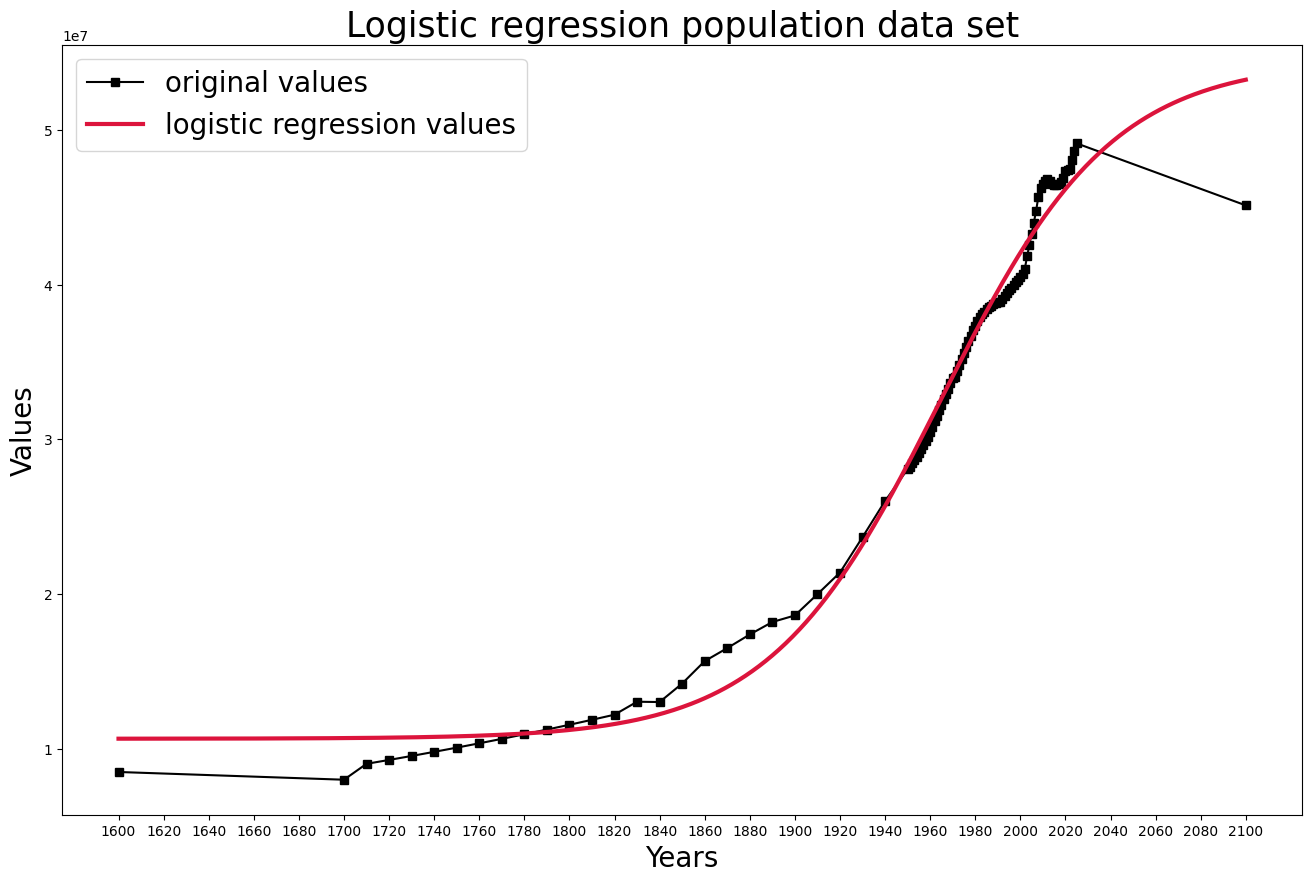

In [98]:
# Logistic regression using method from warmup 15

plt.figure(figsize=(16,10))
#add plot and labels here
all_years = range(1600, 2101, 1)
inputs = data_col['YEAR']
outputs = data_col['POPULATION']
pred_inputs = all_years
# it might be necessary to adjust the bounds argument, 
# determining the extreme acceptable value for the parameters of the logistic function.
# Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
popt, pcov = curve_fit(logistic, inputs, outputs, bounds = ([min(inputs), 0, 0, 0], [max(inputs), 10*8, 10**8, 10**8]))
pred_outputs = logistic(pred_inputs, *popt)

print(f'The optimal choice of parameters for the logistic function, given the sample data, is {popt} (ti, tau, C0, C1).')
plt.figure(figsize=(16,10))
plt.plot(inputs, outputs, 's-', color = 'black', markersize = 6, label = f'original values')
plt.plot(pred_inputs, pred_outputs, color = 'crimson', lw = 3, label = 'logistic regression values')
plt.legend(loc = 'best', fontsize = 20)
plt.xticks(list(pred_inputs[::20]))
plt.xlabel('Years', fontsize = 20)
plt.ylabel('Values', fontsize = 20)
plt.title('Logistic regression population data set', fontsize = 25)
plt.savefig('log_reg_pop.png')
plt.show()

pred_inputs_log_p = pred_inputs
pred_outputs_log_p = pred_outputs

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


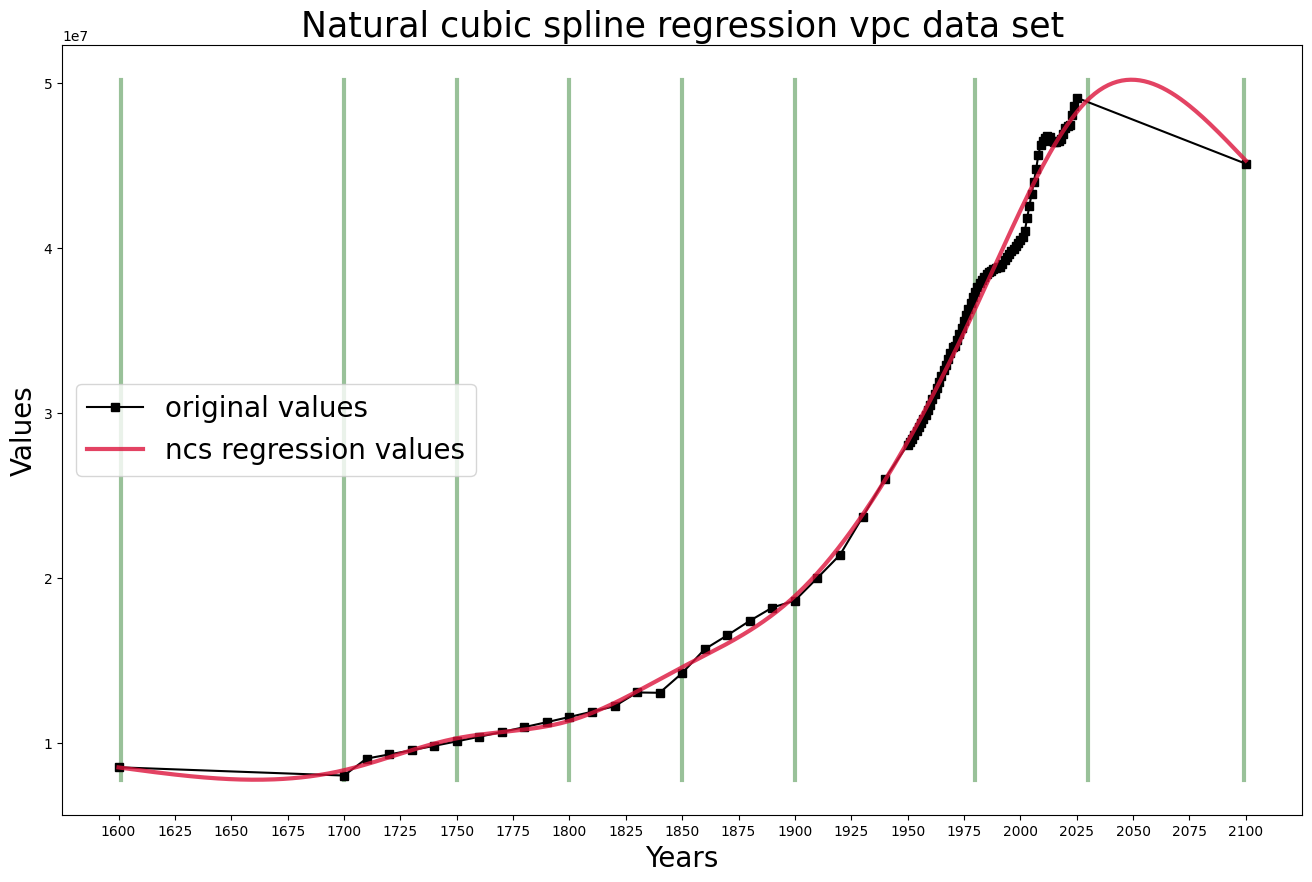

In [99]:
inputs = data_col['YEAR']
outputs = data_col['POPULATION']
pred_inputs = np.array(all_years)

# i choose the knots manually
knots = [1601, 1700, 1750, 1800, 1850, 1900, 1980, 2030, 2099]

# setting up the actual model (training)
ncs_model = ncs.get_natural_cubic_spline_model(inputs, outputs, minval=min(inputs), maxval=max(inputs), knots = knots)

# predicting of the single curve by the model
pred_outputs = ncs_model.predict(pred_inputs)

#plot the knots:
plt.figure(figsize=(16,10))
for knot in knots:
    plt.plot([knot, knot], [min(pred_outputs), max(pred_outputs)], lw = 3, color = 'darkgreen', alpha = 0.4)

plt.plot(inputs, outputs, 's-', color = 'black', markersize = 6, label = f'original values')
plt.plot(pred_inputs, pred_outputs, color = 'crimson', lw = 3, alpha = 0.8, label = 'ncs regression values')
plt.legend(loc = 'best', fontsize = 20)
plt.xticks(list(pred_inputs[::25]))
plt.xlabel('Years', fontsize = 20)
plt.ylabel('Values', fontsize = 20)
plt.title('Natural cubic spline regression vpc data set', fontsize = 25)
plt.savefig('ncs_reg_pop.png')
plt.show()


pred_inputs_ncs_p = pred_inputs
pred_outputs_ncs_p = pred_outputs

In [94]:
exportdata = np.array([pred_inputs, pred_outputs])
exportdata = exportdata.T
print(exportdata.shape)

(501, 2)


In [95]:
filename = 'population.csv'

# Open the file in write mode ('w') and use writerows()
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(exportdata)

print(f"Data successfully exported to {filename} using csv module.")


Data successfully exported to population.csv using csv module.
